In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
import seaborn as sns
%matplotlib inline

/home/seb/py36/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


- The official data for weekly all-cause mortality are here: https://www.bfs.admin.ch/bfs/de/home/statistiken/gesundheit/gesundheitszustand/sterblichkeit-todesursachen.html

- Note that Switzerland reports deaths for ages 0-64 and 65+ separately

- official data on covid-19 fatalities are here: https://www.bag.admin.ch/bag/de/home/krankheiten/ausbrueche-epidemien-pandemien/aktuelle-ausbrueche-epidemien/novel-cov/situation-schweiz-und-international.html#-1934206868

# 1) Parsing the data on total death

## 1.1) 2015-2019

In [2]:
df = pd.read_csv('./total_deaths/ts-d-14.03.04.03-wr_ZR.csv', sep=';', encoding = "ISO-8859-1")
df = df[['KJ', 'Kalenderwoche', 'Endend', 'Alter', 'Anzahl_Todesfalle']]
df = df[~df.KJ.str.contains('#')]
del df['Alter']
df = df.groupby(['KJ', 'Kalenderwoche', 'Endend']).sum().reset_index(drop=False).copy(deep=True)

for yr in range(2015,2020):
    
    dfy = df[df.KJ == '{}'.format(yr)][['Kalenderwoche', 'Anzahl_Todesfalle']]
    
    dfy.columns = ['week', '{}'.format(yr)]
    
    if yr == 2015:    
        dfa = dfy.reset_index(drop=True).copy(deep=True)
    else:
        dfa = pd.merge(dfa, dfy, on=['week'], how='outer').reset_index(drop=True).copy(deep=True)

## 1.2) 2020

In [3]:
df = pd.read_csv('./total_deaths/ts-d-14.03.04.03-wr.csv', sep=';')
df = df[['Endend', 'Woche', 'hochrechnung']]
df['Woche'] = df.Woche.astype('int')
df = df.dropna()
df = df.groupby(['Endend', 'Woche']).sum().reset_index(drop=False)
df = df.sort_values(by=['Woche']).reset_index(drop=True).copy(deep=False)
df['date'] = '2020-' + df.Endend.str[3:5] + '-' + df.Endend.str[:2]
df['2020'] = df.hochrechnung
df['week'] = df.Woche
df = df[['date', '2020', 'week']].copy(deep=True)
df = pd.merge(df, dfa, on=['week'], how='inner')
df = df[['date', 'week'] + ['{}'.format(yr) for yr in range(2015, 2021)]]

First official Covid-19 death in Switzerland is recorded on March 5th (week 10) $\to$ discard all observations prior to week 9.

In [4]:
df = df[df.week >= 9].reset_index(drop=True).copy(deep=True)

Computing cumulative sums

In [5]:
for yr in range(2015, 2021):
    df['cs_{}'.format(yr)] = df['{}'.format(yr)].cumsum()
    del df['{}'.format(yr)]

Computing weekly growth rates for 2015-2019

In [6]:
for yr in range(2015, 2020):
    df['gr_{}'.format(yr)] = df['cs_{}'.format(yr)] / df['cs_{}'.format(yr)].shift(1)
    del df['cs_{}'.format(yr)]

Computing average daily growth rates 2016-2019

In [7]:
df['weekly_growth'] = df.loc[:,['gr_{}'.format(yr) for yr in range(2015,2020)]].mean(axis=1)
df = df.drop(['gr_{}'.format(yr) for yr in range(2015,2020)], axis=1)

Extrapolating forward

In [8]:
df['counterfactual'] = 0
df.loc[0,'counterfactual'] = df.loc[df.date=='2020-03-01','cs_2020'].values[0]

In [9]:
for i in range(1, df.shape[0]):
    df.loc[i,'counterfactual'] = df.loc[i-1,'counterfactual'] * df.loc[i,'weekly_growth']

In [10]:
df = df.drop(['weekly_growth'], axis=1)

# 2) Processing the official Covid-19 deaths

In [11]:
cal = pd.read_csv('./covid_deaths/weeks_dates.csv')
official = pd.read_excel('./covid_deaths/200325_Datengrundlage_Grafiken_COVID-19-Bericht.xlsx',
                         sheet_name='COVID19 Zahlen', skiprows=6)
official = official[~pd.isnull(official['Todesfälle pro Tag'])].reset_index(drop=True)
official = official[['Datum', 'Todesfälle pro Tag']]
official['Datum'] = official.Datum.astype('str')
cal['Datum'] = '2020-' + cal.date.str[3:5] + '-' + cal.date.str[:2]
del cal['date']
official = pd.merge(official, cal, on=['Datum'], how='inner')
del official['Datum']
official.columns = ['deaths', 'week']
official = official.groupby('week').sum().reset_index(drop=False).copy(deep=True)
official['covid_deaths'] = official.deaths.cumsum()
del official['deaths']

# 3) Merging and plotting

In [12]:
df = pd.merge(df, official, on='week', how='left')
df = df.fillna(0)
df['counterfactual_2020_covid'] = df.counterfactual + df.covid_deaths
del df['covid_deaths']
df.index = df.date
del df['date']
del df['week']

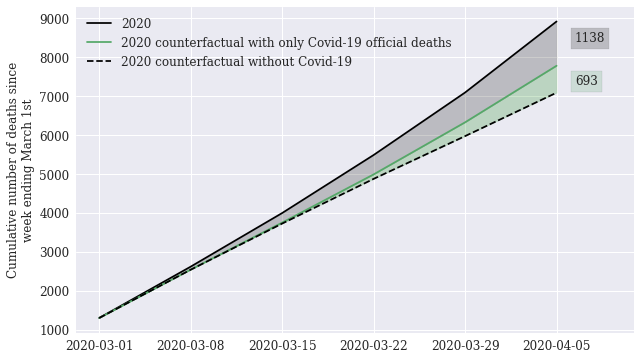

In [13]:
palette = sns.color_palette()

f = plt.figure(figsize=(10,6))
ax = plt.subplot(1,1,1)

ax.plot(df.index,
        df['cs_2020'],
        label='2020',
        color='black')
ax.plot(df.index,
        df['counterfactual_2020_covid'],
        label='2020 counterfactual with only Covid-19 official deaths',
        color = palette[1])
ax.plot(df.index,
        df['counterfactual'],
        label='2020 counterfactual without Covid-19',
        color='black', 
        linestyle = '--')

ax.set_xticks(df.index[[0,1,2,3,4,5]])
ax.fill_between(df.index, df['cs_2020'], df['counterfactual_2020_covid'], color='black', alpha='0.2')
ax.fill_between(df.index, df['counterfactual_2020_covid'], df['counterfactual'], color='green', alpha='0.2')

ax.set_ylabel('Cumulative number of deaths since\nweek ending March 1st',size=12)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.legend(loc='upper left',
          fontsize=12)

plot_margin = 0.6

x0, x1, y0, y1 = plt.axis()
plt.axis((x0,
          x1 + plot_margin,
          y0,
          y1))

plt.text(5.2, 7300, '{}'.format(int(round(df.iloc[-1, 2] - df.iloc[-1, 1]))),
         bbox=dict(facecolor=palette[1], alpha=0.2), size=12)


plt.text(5.2, 8400, '{}'.format(int(round(df.iloc[-1, 0] - df.iloc[-1, 2]))),
         bbox=dict(facecolor='black', alpha=0.2), size=12)

plt.show()

f.savefig('_switzerland.pdf', bbox_inches='tight', dpi=100)

In [14]:
print('Official covid-deaths: {} = green - dashed black'.format(round(df.iloc[-1, 2] - df.iloc[-1, 1])))
print('Excess deaths: {} = solid black - dashed black'.format(round(df.iloc[-1, 0] - df.iloc[-1, 1])))
print('Unexplained excess deaths: {} = solid black - green'.format(round(df.iloc[-1, 0] - df.iloc[-1, 2])))

Official covid-deaths: 693.0 = green - dashed black
Excess deaths: 1831.0 = solid black - dashed black
Unexplained excess deaths: 1138.0 = solid black - green
